## Monte Carlo Control

In [145]:
import sys
sys.path.append("..")
from scripts.k_armbed_bandit.functions import moving_average

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# for visualization of animation
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

# RL gymnasium
import gymnasium as gym
from gymnasium import spaces
import pygame

from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

In [146]:
class Race(gym.Env):
    def __init__(self, 
                 race_track, # race track grid - 0 for track, 1 for start, 2 for goal, 3 for barrier
                 velocity_cap, # max absolute value
                ):

        # entire race track
        self.race_track = race_track

        # get track
        self.track = np.argwhere(self.race_track == 0)
        self.track = [tuple(i) for i in self.track]        

        # get starting points
        self.start_coords = np.argwhere(self.race_track == 1)
        self.start_coords = [tuple(i) for i in self.start_coords]
        
        # get end points
        self.end_coords = np.argwhere(self.race_track == 2)
        self.end_coords = [tuple(i) for i in self.end_coords]

        # get barriers
        self.barriers = np.argwhere(self.race_track == 3)
        self.barriers = [tuple(i) for i in self.barriers]

        # velocity cap
        self.velocity_cap = velocity_cap

        # We have 9 actions, for velocity changes (-1, 0, +1) for each (x, y)
        self.action_space = spaces.Discrete(9)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        """

        self._action_to_velocity_delta = {
                    0: (0, 0), # (x, y) velocity changes
                    1: (0, 1),
                    2: (0, -1),
                    3: (1, 0),
                    4: (-1, 0),
                    5: (1, -1),
                    6: (-1, 1),
                    7: (-1, -1),
                    8: (1, 1),
                }
        
        # back to start at the very beginning and initialize velocity
        self._back_to_start()

    def _get_obs(self):
        return {"agent": self._agent_location}

    def _get_info(self):
        return {"velocity": self._agent_velocity,
                "next_state": self._agent_next_location, # predicted next location
                }
    
    # place agent back to start (if barrier is hit) or env is reset
    def _back_to_start(self):
        # Choose the agent's location uniformly at random
        j = np.random.choice(range(len(self.start_coords)))
        self._agent_location = self.start_coords[j] # random location on any of the start of the track

        # agent velocity is 
        self._agent_velocity = [0, 0] # reset to 0
        self._agent_next_location = self._agent_location # initialize next location

    def reset(self, seed=None, options=None):

        # We need the following line to seed self.np_random
        # this resets the environment?
        super().reset(seed=seed)
        
        self._back_to_start()

        observation = self._get_obs()
        info = self._get_info()

        return observation, info
    
    def step(self, action):
        # Map the action (element of {0,1,2,3...}) to the velocity
        self.velocity_delta = self._action_to_velocity_delta[action]

        # update velocity
        self._agent_velocity[0] = self._agent_velocity[0] + self.velocity_delta[0]
        self._agent_velocity[1] = self._agent_velocity[1] + self.velocity_delta[1]

        # clip velocity so it is never negative? # THIS IS SUTTON'S PROBLEM !!!
        # but maybe we can skip this for now to make it more versatile!!
        # Cap velocity to have absolute value of <= velocity_cap
        self._agent_velocity[0] = np.clip(self._agent_velocity[0],
                                       -self.velocity_cap, self.velocity_cap)
        self._agent_velocity[1] = np.clip(self._agent_velocity[1],
                                       -self.velocity_cap, self.velocity_cap)  

        # velocity must not be (0, 0)
        if tuple(self._agent_velocity) == (0, 0):
            action = np.random.choice(range(1, 9)) # excluding 0
            self._agent_velocity = np.array(self._action_to_velocity_delta[action]) # just get a random action

        # anticipate the next location --  THIS IS WHAT WE USE FOR REWARD COMPUTATION
        self._agent_next_location = [self._agent_location[0] + self._agent_velocity[0], 
                                     self._agent_location[1] + self._agent_velocity[1]]        

        # note not yet terminated
        terminated = False

        # if next location is outside the track, then go back to start!! -- NOPE. JUST STAY IN POSITION BUT MAKE PENALTY = -10
        if tuple(self._agent_next_location) in self.barriers:
            self._back_to_start()
            reward = -100

        # if next location is in the Finish Area then awesome -- just make the finish area large
        elif tuple(self._agent_next_location) in self.end_coords:
            self._agent_location = self._agent_next_location
            terminated = True
            reward = -1

        # otherwise update location
        else:
            self._agent_location = self._agent_next_location
            reward = -1

        # An episode is done iff the agent has reached the target - in the Finish area
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, False, info
    
    def render(self):
        race_track_viz = deepcopy(self.race_track)
        race_track_viz[self._agent_location[0], self._agent_location[1]] = 4

        return race_track_viz

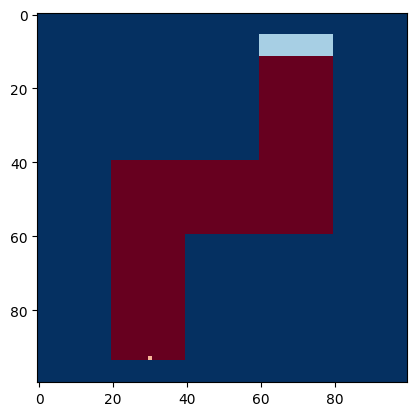

In [147]:
h = 100
w = 100
racecar_track = np.ones((h, w)) * 3

racecar_track[-45:, 20:40] = 0
racecar_track[:-45, 60:80] = 0
racecar_track[40:60, 20:-20] = 0
racecar_track[:6, :] = 3
racecar_track[-6:, :] = 3

j_start = np.argwhere(racecar_track[h-6-1, :] == 0)[10] # start from one pixel
j_finish = np.argwhere(racecar_track[6:12, 60:] == 0)

# for j in j_start:
racecar_track[h-6-1, j_start] = 1

for j in j_finish:
    racecar_track[6:12, 60:][tuple(j)] = 2

plt.imshow(racecar_track, cmap='RdBu')

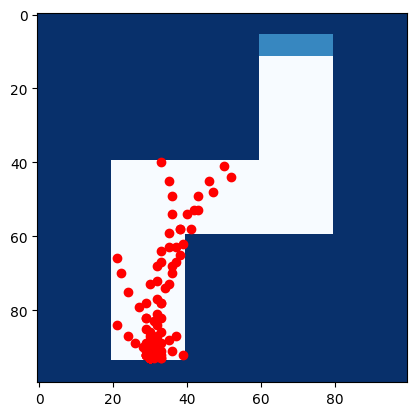

In [148]:
env = Race(race_track=racecar_track, velocity_cap=5)
env.reset()

agent_locs = []
for i in range(100):
    a = np.random.choice(range(9))
    observation, reward, terminated, _, info = env.step(a)
    if terminated:
        env.reset()
    if i % 1 == 0:
        agent_locs += [env._agent_location]

# MC Control
agent_locs = np.array(agent_locs)
plt.imshow(racecar_track, cmap='Blues')
plt.scatter(agent_locs[:, 1], agent_locs[:, 0], c='r', marker='o')

In [149]:
class MC:
    def __init__(self, env, Q_init_val):
        self.env = env
        self.Q, self.state_map = self.init_Q_C(init_val=Q_init_val)
        self.C, _ = self.init_Q_C(init_val=0)
    
    def init_Q_C(self, init_val):

        actions_list = list(self.env._action_to_velocity_delta.values())
        states = self.env.track + self.env.start_coords # + self.env.end_coords

        state_map = {}

        Q = np.ones(shape=(len(states), len(actions_list)))
        for s in range(len(states)):
            for a in range(len(actions_list)):
                if init_val == 'normal':
                    Q[s, a] = np.random.normal()
                else:
                    Q[s, a] = init_val # optimistic starts

                state_map[states[s]] = s

        self.actions_list = actions_list

        return Q, state_map

    def pi(self, s, eps):

        s_idx = self.state_map[s]
        assert type(s_idx) == int

        explore = np.random.choice([True, False], p=[eps, 1-eps])

        if explore:
            a = np.random.choice(range(self.Q.shape[1]))

        else:
            # greedy. randomly break ties
            a = np.random.choice(np.argwhere(self.Q[s_idx, :] == max(self.Q[s_idx, :])).flatten())

        return a
    
    def generate_trajectory(self, eps, get_last_state=False):

        self.env.reset()
        observation = self.env._get_obs()['agent'] # initial observation
        observation = tuple(observation)

        S = []
        A = []
        R = []

        while True:
            a = self.pi(observation, eps=eps)
            A += [a]
            S += [observation]

            observation, reward, terminated, _, info = self.env.step(a)
            observation = tuple(observation['agent'])

            R += [reward]
            if terminated:
                if get_last_state:
                    S += [observation] # for visualization purposes ONLY! NOT FOR TRAINING!
                    assert len(S) - 1 == len(A) == len(R)
                else:
                    assert len(S) == len(A) == len(R)
                self.env.reset()
                break
        
        return S, A, R


    def learn(self, n_iters, eps_b, eps_pi, gamma):

        # compute b(A|S) for greedy action for behavior policy
        proba_greedy_b = 1 - eps_b + eps_b/len(self.actions_list)
        proba_nongreedy_b = eps_b/len(self.actions_list)

        # compute b(A|S) for greedy action for target policy
        proba_greedy_pi = 1 - eps_pi + eps_pi/len(self.actions_list)
        proba_nongreedy_pi = eps_pi/len(self.actions_list)

        # greedy pi defined above
        # loop over many episodes, i = episode
        for i in range(n_iters):
            # b = lambda: epsilon-greedy defined above, b(A|S)
            # generate episode using b -> S, A, R which are sequences from 0 to T-1 (for S, A) or T (for R)
            S, A, R = self.generate_trajectory(eps_b) # follows epsilon-greedy for behavior policy 

            # convert S to indices for Q and C
            S_idx = [self.state_map[s] for s in S]

            G = 0 # init returns for each episode
            W = 1 # initi sampling ratio, weighted, for each episode
            num_steps = len(S) # num steps in episode

            # run episode until termination
            for t in range(num_steps)[::-1]: # reversed from T-1 ... 0

                G = G * gamma + R[t] # this R[t] corresponds to R_{t+1}, yeah confusing I know

                # C - we basically sum up because of weighted importance sampling, 
                # if ordinary sampling then C is basically the number of times St has been visited aka C += 1
                self.C[S_idx[t], A[t]] = self.C[S_idx[t], A[t]] + W

                # the G - Q is the incremental update rule!
                self.Q[S_idx[t], A[t]] = self.Q[S_idx[t], A[t]] + (W / self.C[S_idx[t], A[t]]) * (G - self.Q[S_idx[t], A[t]])
                
                # only select those A ~ b that are A ~ target pi for greedy
                A_max_list = np.argwhere(self.Q[S_idx[t], :] == max(self.Q[S_idx[t], :])).flatten()  
                
                # if eps_pi == 0:
                if A[t] not in A_max_list:
                    break # break inner loop. we cant compute since here, proba_greedy_pi = 0

                else:
                    # W = W * 1 / b[A[t], S[t]] # probability of greedy action eps=0 is 1
                    W = W * proba_greedy_pi / proba_greedy_b # here proba_greedy_pi = 1

                # elif eps_pi > 0: 
                #     if A[t] not in A_max_list:
                #         # not greedy behavior policy, b
                #         W = W * proba_greedy_pi / proba_nongreedy_b

                #     else:
                #         # greedy behavior policy
                #         W = W * proba_greedy_pi / proba_greedy_b

                # print(np.around(W, 1))

In [150]:
# for checkpoint tracking
ckp_idx = 0
agent_checkpoints = {}

# count number of steps
steps_tracker = []

# hyperparam
Q_init_val = -10

# initialize agent
agent = MC(env, Q_init_val)
agent.env.reset()

({'agent': (93, 30)}, {'velocity': [0, 0], 'next_state': (93, 30)})

In [156]:
# Off-policy MC Control algorithm with weighted sampling
eps_b = 0.1
eps_pi = 0
gamma = 0.99

(2440, 9)


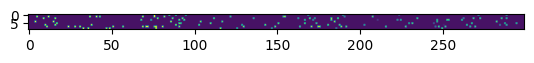

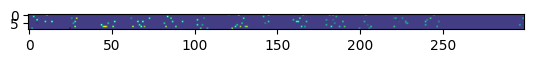

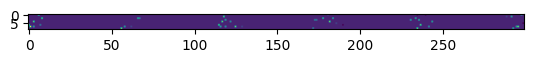

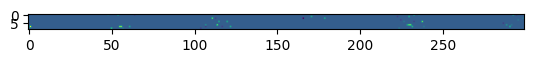

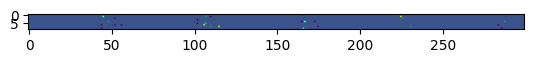

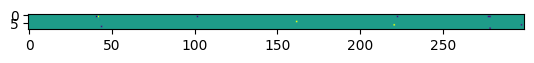

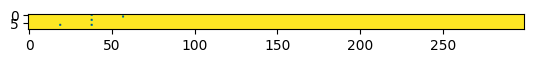

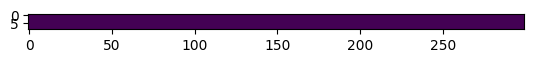

In [161]:
print(agent.Q.shape)
h = 300
for i in range(len(agent.Q)//h):
    t = i * h
    plt.imshow(agent.Q.T[:, t:t+h])
    plt.show()

In [171]:
for i in range(1000):
    n_iters = 5
    agent.learn(n_iters, eps_b, eps_pi, gamma)

    ckp_idx += n_iters
    agent_checkpoints[ckp_idx] = agent

    print(ckp_idx)
    # print(Counter(agent.Q.flatten()))

105
110


3630


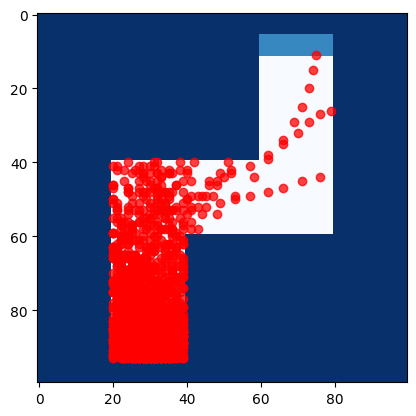

In [170]:
latest_ckp = max(agent_checkpoints.keys())
latest_ckp

agent_test = agent_checkpoints[latest_ckp]
S, A, R = agent_test.generate_trajectory(eps=eps_pi, get_last_state=True)
print(len(S))

agent_locs = np.array(S)
plt.imshow(racecar_track, cmap='Blues')
plt.scatter(agent_locs[:, 1], agent_locs[:, 0], c='r', marker='o', alpha=0.75)
plt.show()

In [ ]:
def animate(iter):
    global agent_locs, racecar_track
    ax.clear()
    ax.imshow(racecar_track, cmap='Blues')
    ax.scatter(agent_locs[iter, 1], agent_locs[iter, 0], c='r', marker='o', s=200)  
    ax.set_axis_off()  
    plt.tight_layout()

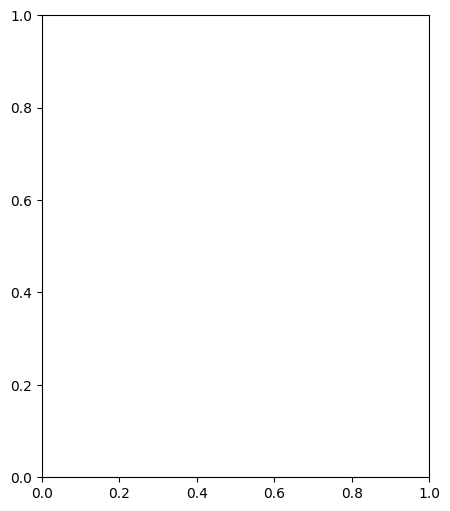

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 6))

In [154]:
agent_locs = np.array(S)
anim = animation.FuncAnimation(fig,
                               animate,
                               frames=np.min([500, len(S)]), 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

<Figure size 640x480 with 0 Axes>